In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import os
from glob import glob

Importing the USG-ground-based comparison data for large bolides and cleaning up the CSV file:

In [3]:
usg_ground_based_comparison = pd.read_csv('usg-ground-based-comparison_EDITED.csv', sep = ',', skip_blank_lines=True).iloc[2:-3]  
# skip the first two rows after header and the last three rows since those are garbage

# forward fill Event and radiant, backward fill dv based on the xlsx file
usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')

# drop every other row since we don't need duplicate rows for event, radiant diff, or dv
# however we want to keep the usg reported speed, zenith angle and other parameters (second row for each event), 
# so we start by dropping the first row rather than the second
usg_ground_based_comparison = usg_ground_based_comparison.iloc[1::2]
# strip whitespace from headers to avoid errors with indexing later
usg_ground_based_comparison.columns = usg_ground_based_comparison.columns.str.strip()

Sort DataFrame alphabetically by the event name (to match the order in which csvs are read from the `event` directory and its subdirectories) in-place:

In [4]:
usg_ground_based_comparison.sort_values('Event', inplace=True)

Note that all parameters (e.g. azimuth, zenith angle, speed, height) in the `usg_ground_based_comparison` dataframe are the USG-reported data rather than ground-based. The LCs (with intensity and magnitude measurements) for all events **other than Chelyabinsk** are also USG LCs; Chelyabinsk instead uses ground-based data

Now plotting speed difference and radiant difference against speed, recreating Figs. $2$ and $3$ of Brown and Borovicka:

In [6]:
# usg_ground_based_comparison = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison[['DV', 'Radiant Diff']], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')
# usg_ground_based_comparison_dv = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison['DV'], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')
# usg_ground_based_comparison_drad = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison['Radiant Diff'], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')

# convert Speed, DV, Radiant Diff, Radiant Zenith Angle, Height to numeric to avoid errors
cols_to_convert = ['Speed', 'DV', 'Radiant Diff', 'Radiant Zenith Angle', 'Height']
usg_ground_based_comparison[cols_to_convert] = usg_ground_based_comparison[cols_to_convert].apply(pd.to_numeric, errors='coerce', axis=1)

# usg speed, dv, radiant_diff
usg_speed = usg_ground_based_comparison['Speed']
dv = usg_ground_based_comparison['DV']
radiant_diff = usg_ground_based_comparison['Radiant Diff']

Fig. $2$ of B&B:

(Text(0.5, 0, 'Speed (km/s)'), Text(0, 0.5, 'Speed difference (km/s)'))

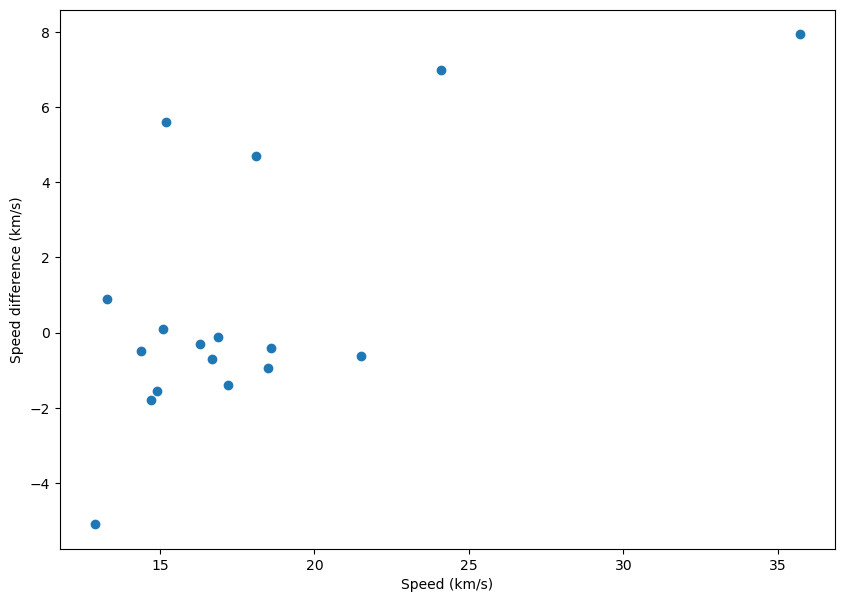

In [7]:
plt.figure(figsize = (10, 7))
plt.scatter(usg_speed, dv)
plt.xlabel('Speed (km/s)'), plt.ylabel('Speed difference (km/s)')

Fig. $3$ of B&B:

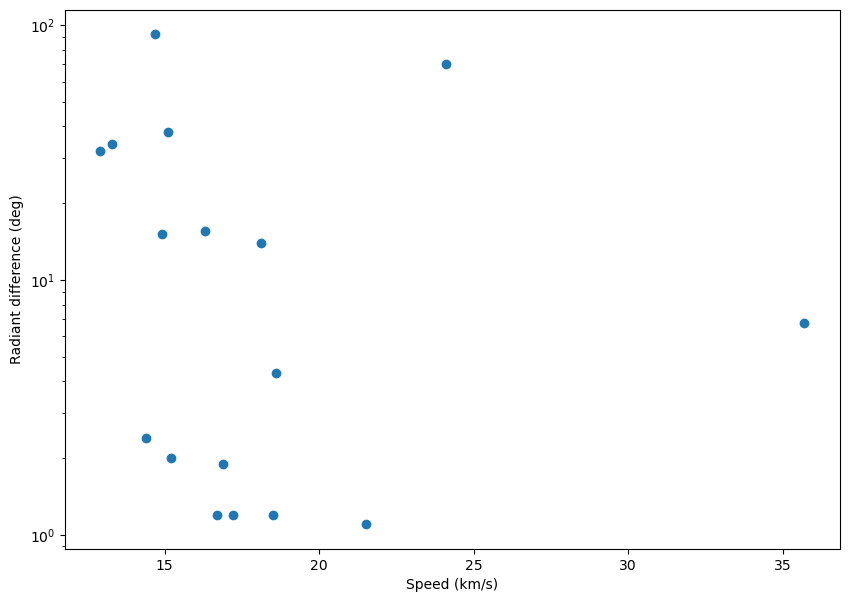

In [8]:
plt.figure(figsize = (10, 7))
# note that we use the usg reported speed (which is in our processed df) rather tahn the ground based speed (which we dropped earlier)
plt.scatter(usg_speed,radiant_diff)
plt.xlabel('Speed (km/s)'), plt.ylabel('Radiant difference (deg)')
plt.yscale('log')  # log y scale following B&B

Now plotting speed difference and radiant difference against peak intensity and lightcurve duration (from the LC data):

Get all intensity and magnitude `.csv` files for all the events (check all subdirectories of 'events') for `.csv` files, then sort to make sure they are in alphabetical order by event folder name:

In [9]:
# should get all the intensity and magnitude files in the event folder name
int_files = [file for path, subdir, files in os.walk('events') for file in glob(os.path.join(path,'*_INT.csv'))]
mag_files = [file for path, subdir, files in os.walk('events') for file in glob(os.path.join(path,'*_MAG.csv'))]
# sort lists alphabetically, by the event folder name
int_files.sort()
mag_files.sort()

Define functions to get the peak intensities and lightcurve durations from the LC data:

In [10]:
def get_peak_intensity(intensity_csv_path):
    """
    Gets the peak intensity of a fireball event from an intensity CSV generated by the CNEOS_LC_INT_MAY-format.py script, 
    given the path 'intensity_csv_path' to the event

    param str: intensity_csv_path: file path to the intensity CSV for the fireball event

    return float: returns peak intensity value as a float
    """
    intensity_df = pd.read_csv(intensity_csv_path, header=None, names=['Time (s)', 'Intensity (W/sr)'])  # reading intensity data
    return np.float64(intensity_df['Intensity (W/sr)'].max())  # get the maximum intensity 
    
def get_lightcurve_duration(magnitude_csv_path, noise_threshold=-17.):
    """
    Gets the lightcurve duration of a fireball event from a magnitude CSV generated by the CNEOS_LC_INT_MAY-format.py script, given the path
    'magnitude_csv_path' to the event

    param str magnitude_csv_path: file path to the magnitude CSV for the fireball event
    default param float noise_threshold: noise threshold (anything below this is considered noise rather than a possible LC signal); 
    set to -17 by default

    return float duration: returns lightcurve duration as a float
    """
    # get the csv data, coerce any non numeric values to nans
    magnitude_df = pd.read_csv(magnitude_csv_path, header=None, names=['Time (s)', 'Bolometric Magnitude']).apply(pd.to_numeric, errors='coerce')
    # replace all nas with infinity, because np.inf < noise_threshold always evaluates to False (which we want)
    magnitude_df.fillna(np.inf, inplace=True)
    # get all indices for which the bolometric magnitude is less than the noise threshold
    # (this is the actual light curve as anything below (greater than) that is noise)
    filtered_magnitude_df = magnitude_df['Bolometric Magnitude'] < noise_threshold
    # generate the dataframe for cumulative summation to detect changes from False to True in the column and vice versa
    cumsum_df = filtered_magnitude_df != filtered_magnitude_df.shift()
    # create dataframe with the count, start and end times of every consecutive sequence of either 'True' or 'False' in the data
    start_end_time_df = magnitude_df.groupby(cumsum_df.cumsum()).agg({'Time (s)': ['count', 'min', 'max']}).reset_index()
    start_end_time_df.columns = start_end_time_df.columns.droplevel()
    # take the actual light curve to be the longest consecutive sequence of "True" in the data (consecutive sequence of values less than
    # -17 bolometric magnitude)
    # if first sequence is noise (below noise threshold), remove every other sequence starting with the first one, 
    # since the df alternates noise-signal-noise-signal etc
    # otherwise remove every other sequence starting with the second one since the df alternates signal-noise-signal-noise etc.
    # print(magnitude_df['Bolometric Magnitude'][0] >= noise_threshold)
    if magnitude_df['Bolometric Magnitude'][0] >= noise_threshold:
        start_end_time_df = start_end_time_df.iloc[1::2].reset_index()  # need to reset indices again because cut the file by iloc again
    elif magnitude_df['Bolometric Magnitude'][0] < noise_threshold:
        start_end_time_df = start_end_time_df.iloc[::2].reset_index() 
    # get the start and end times of the lcs
    lc_start_time = start_end_time_df.iloc[start_end_time_df['count'].idxmax()]['min']
    lc_end_time = start_end_time_df.iloc[start_end_time_df['count'].idxmax()]['max']
    # print(lc_start_time, lc_end_time)
    # duration is the end minus the start time
    duration = lc_end_time - lc_start_time
    # return duration
    return duration

Get the peak intensities and lightcurve durations above $-17$ and $-12$ magnitude for all the fireball intensity and magnitude `.csv` files:

In [11]:
peak_intensities = np.array([get_peak_intensity(csv_file) for csv_file in int_files])
lc_durations_17 = np.array([get_lightcurve_duration(csv_file) for csv_file in mag_files])
lc_durations_12 = np.array([get_lightcurve_duration(csv_file, noise_threshold=-12.) for csv_file in mag_files])

Now plot them against the speed and radiant difference:

Speed and Radiant differences vs. Peak intensity:

Text(0, 0.5, 'Radiant Difference (deg)')

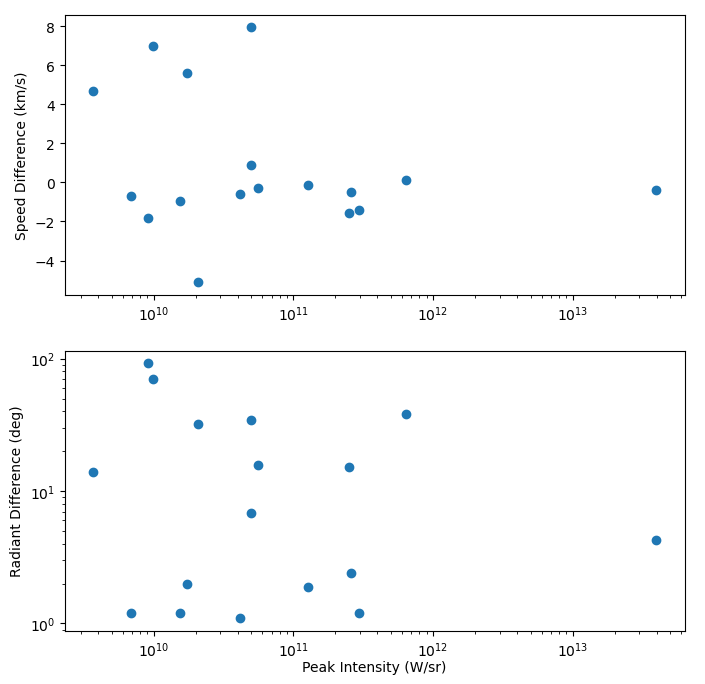

In [12]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(peak_intensities, dv)
# radiant diff
ax2.scatter(peak_intensities, radiant_diff)
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# set logarithmic x scales for intensity for both
ax1.set_xscale('log')
ax2.set_xscale('log')
# label
ax.set_xlabel('Peak Intensity (W/sr)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# plt.tight_layout()

Speed and Radiant differences vs. LC duration:

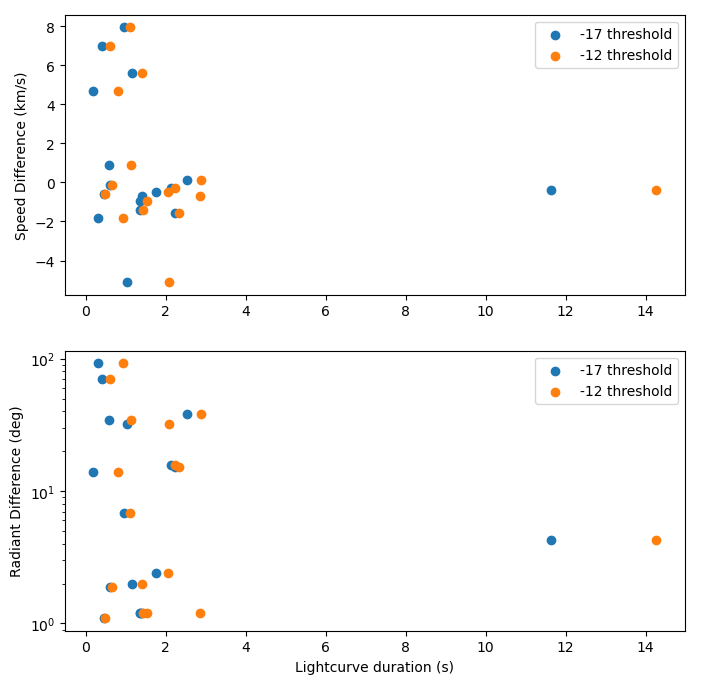

In [13]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(lc_durations_17, dv, label = '-17 threshold')
ax1.scatter(lc_durations_12, dv, label = '-12 threshold')
# radiant diff
ax2.scatter(lc_durations_17, radiant_diff, label = '-17 threshold')
ax2.scatter(lc_durations_12, radiant_diff, label = '-12 threshold')
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# label
ax.set_xlabel('Lightcurve duration (s)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# legend
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
# plt.tight_layout()

Now plot the speed and radiant difference vs. the entry angle, colour-coding by duration, peak intensity, total energy (integrated intensity), and height of peak brightness respectively (for a total of $8$ plots):

Define function to compute the total energy (integrated intensity):

In [14]:
def get_total_energy(intensity_csv_path):
    """
    Gets the total energy of a fireball event from the intensity CSV generated by the CNEOS_LC_INT_MAY-format.py 
    script by numerically integrating over intensity, given the path 'intensity_csv_path' to the event

    param str: intensity_csv_path: file path to the intensity CSV for the fireblal event

    return float: returns peak intensity value as a float
    """
    intensity_df = pd.read_csv(intensity_csv_path, header=None, names=['Time (s)', 'Intensity (W/sr)'])  # reading the intensity data
    # numerically integrate over the intensity to get total energy using the trapezoid rule, since we have a dataframe of 
    # times and intensities at the time
    # only take the positive intensities since negative intensities are unphysical
    # could remove some of this code if it slows it down a lot later...
    positive_intensity_df = intensity_df.copy()
    negative_intensity_df = intensity_df.copy()
    # split into positive and negative areas separately
    positive_intensity_df['Intensity (W/sr)'].clip(lower=0., inplace=True)  # ignore negative intensities
    negative_intensity_df['Intensity (W/sr)'].clip(upper=0., inplace=True)  # ignore positive intensities here
    # perform numerical integration over the total intensity using scipy.integrate.trapezoid (trapezoid rule) to get the total energy
    total_energy = scipy.integrate.trapezoid(y=positive_intensity_df['Intensity (W/sr)'], x=positive_intensity_df['Time (s)'])
    # return the total energy
    return total_energy

Get the integrated intensities (total energies) from the fireball `.csv` intensity files: 

In [15]:
integrated_intensities = np.array([get_total_energy(csv_file) for csv_file in int_files])

Getting the entry angles and heights of peak brightness:

In [45]:
# zenith/entry angles
zenith_angle = usg_ground_based_comparison['Radiant Zenith Angle']
entry_angle = 90 - zenith_angle  # entry angle is 90 degrees minus the radiant zenith angle
# heights of peak brightness
heights = usg_ground_based_comparison['Height']

Now plotting speed and radiant difference vs entry angle, colour-coding by duration at $\geq -17$ magnitude, peak intensity, total energy and height of peak brightness. Take $\log_10$ of duration, peak intensity, and total energy to scale the colourbar better:

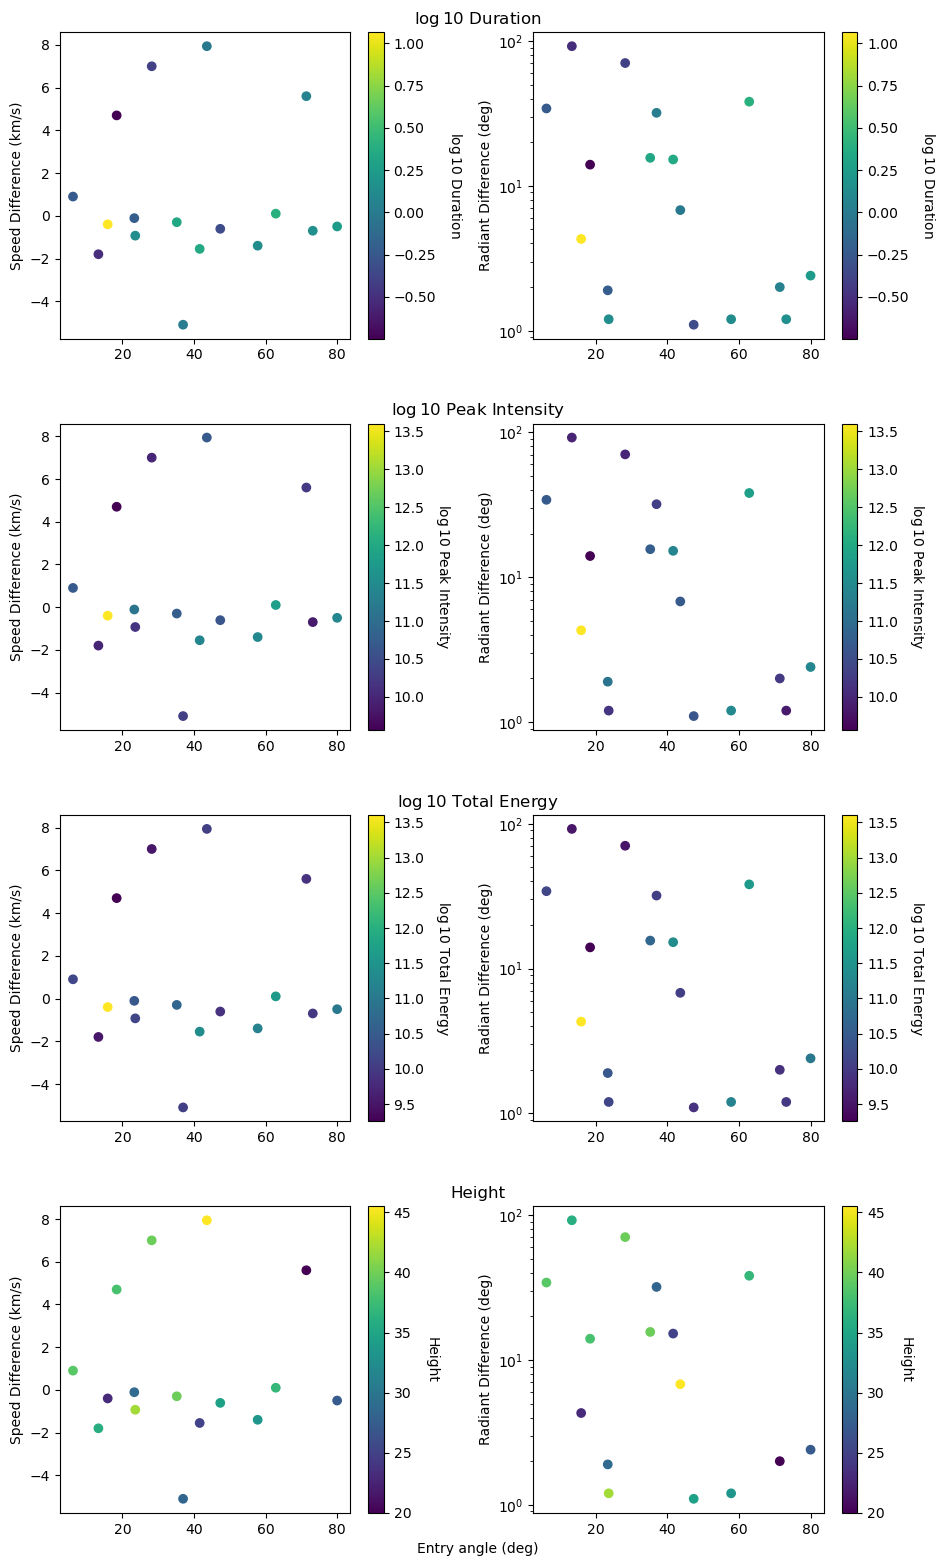

In [67]:
fig = plt.figure(figsize = (10, 16))
# make the big subplots to put labels on
ax_big1 = fig.add_subplot(411)
ax_big2 = fig.add_subplot(412)
ax_big3 = fig.add_subplot(413)
ax_big4 = fig.add_subplot(414)
# make the small plots to actually plot on
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)
# Turn off the axis lines and ticks of the big subplots
ax_big1.spines['top'].set_color('none')
ax_big1.spines['bottom'].set_color('none')
ax_big1.spines['left'].set_color('none')
ax_big1.spines['right'].set_color('none')
ax_big1.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big2.spines['top'].set_color('none')
ax_big2.spines['bottom'].set_color('none')
ax_big2.spines['left'].set_color('none')
ax_big2.spines['right'].set_color('none')
ax_big2.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big3.spines['top'].set_color('none')
ax_big3.spines['bottom'].set_color('none')
ax_big3.spines['left'].set_color('none')
ax_big3.spines['right'].set_color('none')
ax_big3.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big4.spines['top'].set_color('none')
ax_big4.spines['bottom'].set_color('none')
ax_big4.spines['left'].set_color('none')
ax_big4.spines['right'].set_color('none')
ax_big4.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff against entry angle, colour-coding by duration, peak intensity, total energy and height of peak brightness
p1 = ax1.scatter(entry_angle, dv, c=np.log10(lc_durations_17), cmap='viridis')  # duration
p3 = ax3.scatter(entry_angle, dv, c=np.log10(peak_intensities), cmap='viridis') # peak intensity
p5 = ax5.scatter(entry_angle, dv, c=np.log10(integrated_intensities), cmap='viridis')  # total energy
p7 = ax7.scatter(entry_angle, dv, c=heights, cmap='viridis')  # height of peak brightness
# radiant diff against entry angle, colour-coding by duration, peak intensity, total energy and height of peak brightness
p2 = ax2.scatter(entry_angle, radiant_diff, c=np.log10(lc_durations_17), cmap='viridis')  # duration
p4 = ax4.scatter(entry_angle, radiant_diff, c=np.log10(peak_intensities), cmap='viridis')  # peak intensity
p6 = ax6.scatter(entry_angle, radiant_diff, c=np.log10(integrated_intensities), cmap='viridis')  # total energy
p8 = ax8.scatter(entry_angle, radiant_diff, c=heights, cmap='viridis')  # height of peak brightness
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
ax4.set_yscale('log')
ax6.set_yscale('log')
ax8.set_yscale('log')
# colourbars for each of the plots
cbar1 = fig.colorbar(p1, ax=ax1)
cbar2 = fig.colorbar(p2, ax=ax2)
cbar1.ax.set_ylabel(r'$\log{10}$ Duration', rotation=270)
cbar2.ax.set_ylabel(r'$\log{10}$ Duration', rotation=270)
cbar1.ax.get_yaxis().labelpad=20
cbar2.ax.get_yaxis().labelpad=20
cbar3 = fig.colorbar(p3, ax=ax3)
cbar4 = fig.colorbar(p4, ax=ax4)
cbar3.ax.set_ylabel(r'$\log{10}$ Peak Intensity', rotation=270)
cbar4.ax.set_ylabel(r'$\log{10}$ Peak Intensity', rotation=270)
cbar3.ax.get_yaxis().labelpad=20
cbar4.ax.get_yaxis().labelpad=20
cbar5 = fig.colorbar(p5, ax=ax5)
cbar6 = fig.colorbar(p6, ax=ax6)
cbar5.ax.set_ylabel(r'$\log{10}$ Total Energy', rotation=270)
cbar6.ax.set_ylabel(r'$\log{10}$ Total Energy', rotation=270)
cbar5.ax.get_yaxis().labelpad=20
cbar6.ax.get_yaxis().labelpad=20
cbar7 = fig.colorbar(p7, ax=ax7)
cbar8 = fig.colorbar(p8, ax=ax8)
cbar7.ax.set_ylabel('Height', rotation=270)
cbar8.ax.set_ylabel('Height', rotation=270)
cbar7.ax.get_yaxis().labelpad=20
cbar8.ax.get_yaxis().labelpad=20

# label
ax_big1.set_title('$\log{10}$ Duration')
# ax_big1.set_xlabel('Entry angle (deg)')
ax_big2.set_title('$\log{10}$ Peak Intensity')
# ax_big2.set_xlabel('Entry angle (deg)')
ax_big3.set_title('$\log{10}$ Total Energy')
# ax_big3.set_xlabel('Entry angle (deg)')
ax_big4.set_title('Height')
ax_big4.set_xlabel('Entry angle (deg)')
ax1.set_ylabel('Speed Difference (km/s)')
ax3.set_ylabel('Speed Difference (km/s)')
ax5.set_ylabel('Speed Difference (km/s)')
ax7.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
ax4.set_ylabel('Radiant Difference (deg)')
ax6.set_ylabel('Radiant Difference (deg)')
ax8.set_ylabel('Radiant Difference (deg)')
plt.tight_layout()


Text(0, 0.5, 'Radiant Difference (deg)')

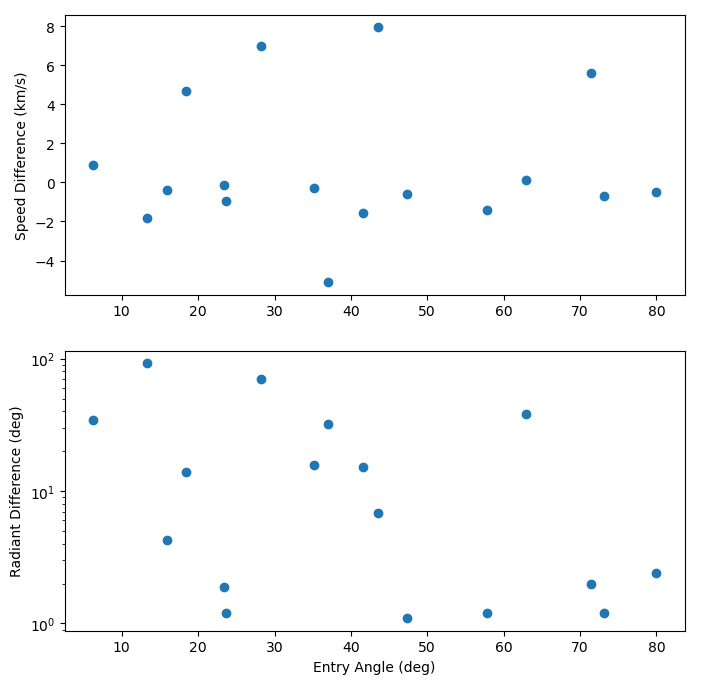

In [42]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(entry_angle, dv)
# radiant diff
ax2.scatter(entry_angle, radiant_diff)
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# label
ax.set_xlabel('Entry Angle (deg)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# plt.tight_layout()

Plot speed difference and radiant difference against trajectory length, begin height and end height:

In [21]:
lengths = usg_ground_based_comparison['Length (km)']
begin_heights = usg_ground_based_comparison['Begin Height (km)']
end_heights = usg_ground_based_comparison['End Height (km)']

Length:

Text(0, 0.5, 'Radiant Difference (deg)')

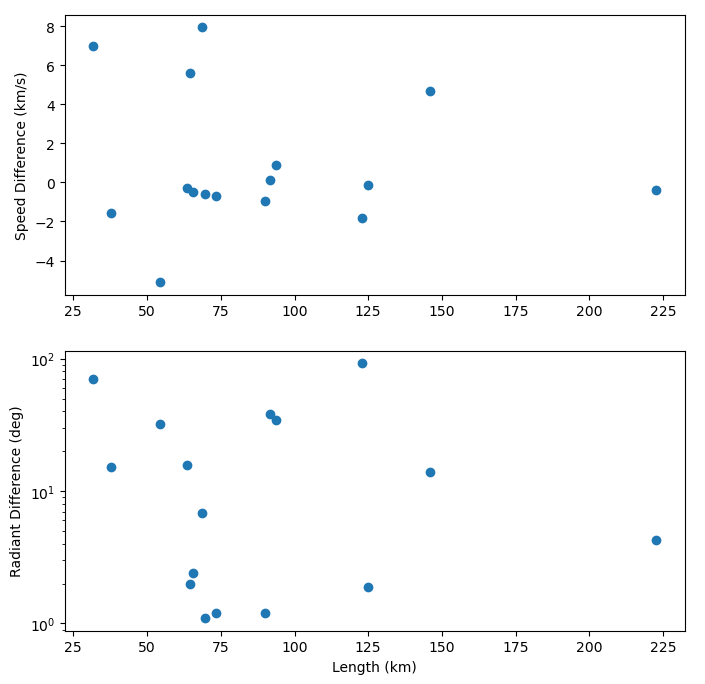

In [22]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(lengths, dv)
# radiant diff
ax2.scatter(lengths, radiant_diff)
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# label
ax.set_xlabel('Length (km)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# plt.tight_layout()

Begin/end height:

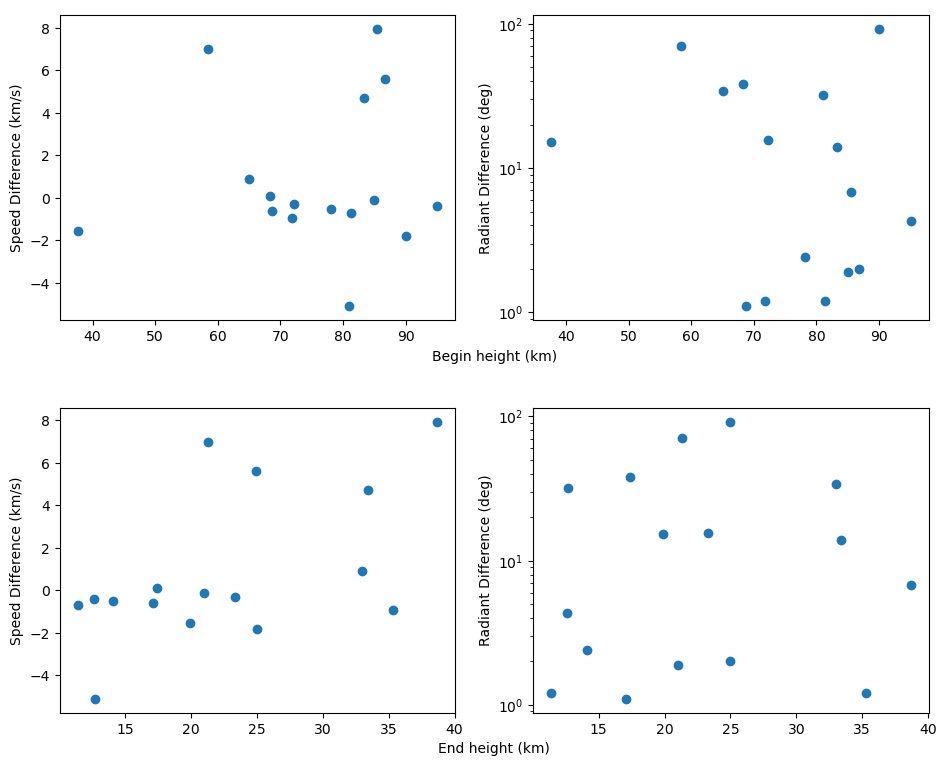

In [33]:
fig = plt.figure(figsize = (10, 8))
# make subplots
ax_big1 = fig.add_subplot(211)    # The big subplot
ax_big2 = fig.add_subplot(212)   # big suplot 2
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
# Turn off axis lines and ticks of the big subplots
ax_big1.spines['top'].set_color('none')
ax_big1.spines['bottom'].set_color('none')
ax_big1.spines['left'].set_color('none')
ax_big1.spines['right'].set_color('none')
ax_big1.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax_big2.spines['top'].set_color('none')
ax_big2.spines['bottom'].set_color('none')
ax_big2.spines['left'].set_color('none')
ax_big2.spines['right'].set_color('none')
ax_big2.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff against begin/end heights
ax1.scatter(begin_heights, dv)  # begin
ax3.scatter(end_heights, dv)  # end
# radiant diff against begin/end heights
ax2.scatter(begin_heights, radiant_diff)  # begin
ax4.scatter(end_heights, radiant_diff)  # end
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
ax4.set_yscale('log')
# label
ax_big1.set_xlabel('Begin height (km)')
ax_big2.set_xlabel('End height (km)')
ax1.set_ylabel('Speed Difference (km/s)')
ax3.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
ax4.set_ylabel('Radiant Difference (deg)')
plt.tight_layout()

#### Notes: 

**TODO:**
Need to generate the entry angle vs. radiant/speed difference plots with the colour-coding mentioned above